# Monte Carlo Simulation For FX Asset Risk Assessment
---

A Monte Carlo Simulation is named after the Monte Carlo area in Monaco, which is also home to a famous casino of the same name. A Monte Carlo simulation is a batch of simulations to assess risk and stress test for financial instruments.

[FX Data](https://www.kaggle.com/datasets/dhruvildave/currency-exchange-rates?resource=download) sourced from Kaggle under [ODC-By v1.0](https://opendatacommons.org/licenses/by/1-0/index.html)

In [21]:
# Import prerequisites
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import Daily FX Pair Data

In [22]:
# Import fx data
fx_data = pd.read_csv("fx_rates.csv")

# Filter by date
start_date = "2020-08-29"
end_date = "2021-08-29"
fx_data = fx_data[(fx_data['date'] >= start_date) & (fx_data['date'] <= end_date)]

fx_data

,slug,date,open,high,low,close,currency
4275,GBP/EGP,2020-08-31,21.144287,21.227949,20.920570,21.142630,EGP
4276,GBP/EGP,2020-09-01,21.183609,21.376516,21.109810,21.183372,EGP
4277,GBP/EGP,2020-09-02,21.238482,21.240629,20.996525,21.239674,EGP
4278,GBP/EGP,2020-09-03,21.151613,21.151613,20.829466,21.152687,EGP
4279,GBP/EGP,2020-09-04,20.940861,21.025217,20.803146,20.941328,EGP
...,...,...,...,...,...,...,...
1453029,USD/MXN,2021-08-23,20.377100,20.440399,20.266140,20.381500,MXN
1453030,USD/MXN,2021-08-24,20.317129,20.360830,20.238400,20.317949,MXN
1453031,USD/MXN,2021-08-25,20.202400,20.347589,20.160601,20.206100,MXN
1453032,USD/MXN,2021-08-26,20.228861,20.384501,20.211901,20.216101,MXN


### Fetch Portfolio Holdings

In [23]:
# Fetch data from FX rates DF
def get_data(source, fx_pairs):
    data = source[source['slug'].isin(fx_pairs)]
    data = data.drop(columns=['open', 'high', 'low', 'currency'])
    
    # Set date to index
    data = pd.pivot_table(data, index='date', columns='slug', values='close')
    
    # Calculate needed values
    daily_returns = data.pct_change()
    mean_returns = daily_returns.mean()
    covariance_mtx = daily_returns.cov()

    return data, mean_returns, covariance_mtx

# Filter out and keep target pairs (AKA our FX portfolio holdings)
target_pairs = ['USD/JPY', 'USD/GBP', 'USD/EUR']

target_data, mean_returns, covariance_mtx = get_data(fx_data, target_pairs)

### Monte-Carlo Simulation

In [24]:
# Simulation Settings
num_sims = 100
time_frame = 100 # Days
initial_value = 100000 # Initial value of portfolio

# Set weights and normalize
weights = np.random.random(len(mean_returns))
weights = weights / np.sum(weights)

# Store Results
mean_matrix = np.full(shape=(time_frame, len(weights)), fill_value=mean_returns).T

sim_results = np.full(shape=(time_frame, num_sims), fill_value=0.0)

# Run simulations
for sim in range(num_sims):

    # Implement Cholesky Decom
    Z = np.random.normal(size=(time_frame, len(weights)))
    L = np.linalg.cholesky(covariance_mtx)

    R = mean_matrix + np.inner(L, Z)

    # Add to results
    sim_results[:,sim] = np.cumprod(np.inner(weights, R.T)+1) * initial_value

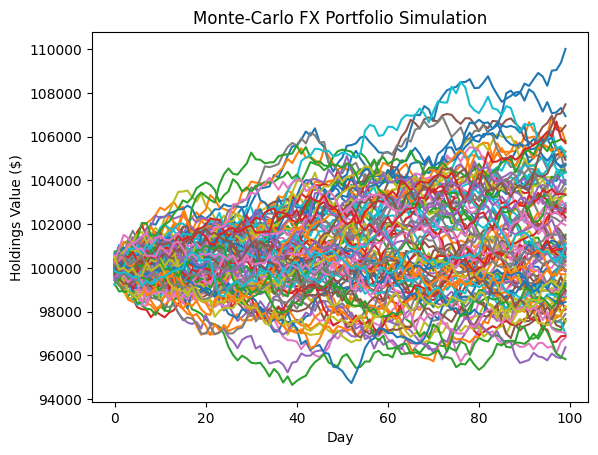

In [25]:
# Plot simulation results
plt.plot(sim_results)
plt.ylabel("Holdings Value ($)")
plt.xlabel("Day")
plt.title("Monte-Carlo FX Portfolio Simulation")
plt.show()